<a href="https://colab.research.google.com/github/ritwikraha/CV-Practice/blob/master/Getting_Started_with_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq diffusers
!pip install -qq accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 5.5 MB/s eta 0:00:00


In [ ]:
import tqdm
import torch
import PIL
import PIL.Image
import numpy as np
import diffusers
from PIL import Image
from diffusers import UNet2DModel
from diffusers import AutoPipelineForText2Image
from diffusers import DDPMPipeline
from diffusers import DDPMScheduler

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Introduction

*   In this tutorial we will be making use of the diffusers library
*   Use diffusers to generate an image
*   Learn about the model and scheduler from DDPM



## A brief Primer on Diffusion

The diffusers library is to make diffusion models accessible to a wide range of deep learning practitioners.
With this in mind, we aimed at building a library that is **easy to use**, **intuitive to understand**, and **easy to contribute to**.

As a quick recap, diffusion models are machine learning systems that are trained to *denoise* random gaussian noise step by step, to get to a sample of interest, such as an *image*.




> Diffusion probabilistic models are parameterized Markov chains trained to gradually denoise data. We estimate parameters of the generative process p.




The underlying model, often a neural network, is trained to predict a way to slightly denoise the image in each step. After certain number of steps, a sample is obtained.

The process is illustrated by the following design:
![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusion-process.png)


The diffusion process consists in taking random noise of the size of the desired output and pass it through the model several times. The process ends after a given number of steps, and the output image should represent a sample according to the training data distribution of the model, for instance an image of a butterfly.

During training we show many samples of a given distribution, such as images of butterfly. After training, the model will be able to process random noise to generate similar butterfly images.

- **The role of the Model**: Without going in too much detail, the model is usually not trained to directly predict a slightly less noisy image, but rather to predict the "noise residual" which is the difference between a less noisy image and the input image (for a diffusion model called "DDPM").

- **The role of the Scheduler**: To do the denoising process, a specific noise scheduling algorithm is thus necessary and "wrap" the model to define how many diffusion steps are needed for inference as well as how to *compute* a less noisy image from the model's output. Here is where the different **schedulers** of the diffusers library come into play.

- **The role of the pipeline**: Finally, a **pipeline** groups together a **model** and a **scheduler** and make it easy for an end-user to run a full denoising loop process. We'll start with the pipelines and dive deeper into its implementation before taking a closer look at models and schedulers.

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained(
	"runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

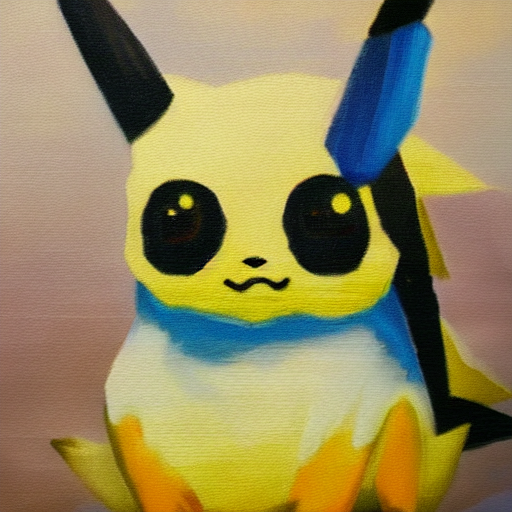

In [ ]:
image = pipeline(
	"impressionist oil painting of pikachu, backlight, centered composition, masterpiece, photorealistic, 8k"
).images[0]
image

## But what is `Autopipeline`?

Diffusers is able to complete many different tasks, and you can often reuse the same pretrained weights for multiple tasks such as text-to-image, image-to-image, and inpainting. If you’re new to the library and diffusion models though, it may be difficult to know which pipeline to use for a task.


The AutoPipeline class is designed to simplify the variety of pipelines in HuggingFace Diffusers. It is a generic, task-first pipeline that lets you focus on the task.

The AutoPipeline automatically detects the correct pipeline class to use, which makes it easier to load a checkpoint for a task without knowing the specific pipeline class name.


## What are some other pipelines and models?

The most common text-to-image models are Stable Diffusion v1.5, Stable Diffusion XL (SDXL), and Kandinsky 2.2. There are also ControlNet models or adapters that can be used with text-to-image models for more direct control in generating images. The results from each model are slightly different because of their architecture and training process, but no matter which model you choose, their usage is more or less the same.

Let’s use the same prompt for each model and compare their results.

`runwayml/stable-diffusion-v1-5`

`stabilityai/stable-diffusion-xl-base-1.0`

`kandinsky-community/kandinsky-2-2-decoder`







model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

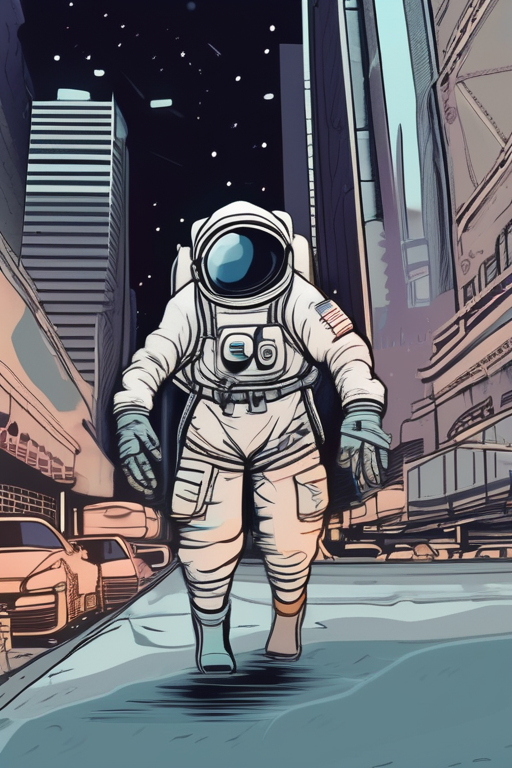

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained(
	"stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

prompt = "Astronaut in a 1700 New York, cold color palette, muted colors, detailed, 8k"
image = pipeline(prompt = prompt,
                 height=768,
                 width=512,
                 ).images[0]
image

Under the hood, `AutoPipelineForText2Image`:

- automatically detects a "stable-diffusion" class from the model_index.json file
- loads the corresponding text-to-image StableDiffusionPipeline based on the "stable-diffusion" class name

You can also pass any additional arguments specific to the pipeline class such as `strength`, `guidance_scale`, `num_inference_steps`.

Note: The guidance_scale parameter affects how much the prompt influences image generation. A lower value gives the model “creativity” to generate images that are more loosely related to the prompt.

  0%|          | 0/70 [00:00<?, ?it/s]

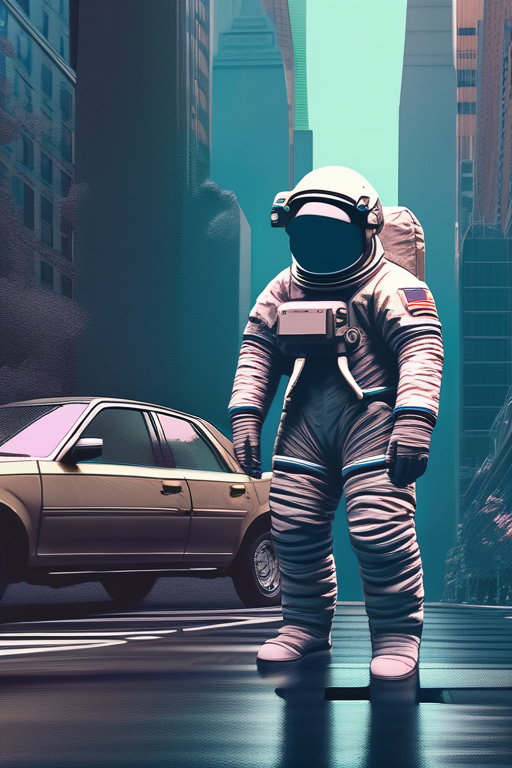

In [ ]:
image = pipeline(prompt,
                 height=768,
                 width=512,
                 num_inference_steps=70,
                 strength=0.75,
                 guidance_scale=10.5,
                 ).images[0]
image

## Diving Deep into a Pipeline

In this tutorial, you’ll learn how to use models and schedulers to assemble a diffusion system for inference, starting with a basic pipeline and then progressing to the Stable Diffusion pipeline.



## The DDPM Pipeline

Let's begin by importing a pipeline. We'll use the `google/ddpm-celebahq-256` model.

It's a model following the [Denoising Diffusion Probabilistic Models (DDPM) algorithm](https://arxiv.org/abs/2006.11239) trained on a dataset of celebrities images.

We can import the `DDPMPipeline`, which will allow you to do inference with a couple of lines of code:


In [ ]:
ddpm_pipeline = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
ddpm_pipeline.to("cuda")

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.25.0",
  "_name_or_path": "google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

To generate an image, we simply run the pipeline and don't even need to give it any input, it will generate a random initial noise sample and then iterate the diffusion process.

The pipeline returns as output a dictionary with a generated `sample` of interest.

  0%|          | 0/1000 [00:00<?, ?it/s]

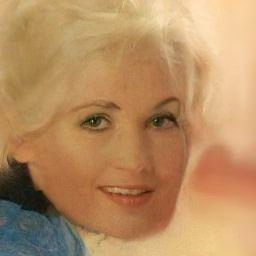

In [ ]:
images = ddpm_pipeline().images
images[0]

Let’s breakdown the pipeline and take a look at what’s happening under the hood. Here we are taking a repository from HuggingFace and extracting the `scheduler` and the `model` from it. You can take other repositories from HuggingFace to experiment.

`repo_id = "google/ddpm-church-256"`

`repo_id = "google/ddpm-cat-256"`





In [ ]:
repo_id = "google/ddpm-celebahq-256"

In [ ]:
scheduler = DDPMScheduler.from_pretrained(repo_id)
model = UNet2DModel.from_pretrained(repo_id).to("cuda")

### Models

Instances of the model class are neural networks that take a noisy `sample` as well as a `timestep` as inputs to predict a less noisy output `sample`. Let's load a pre-trained model and play around with it to understand the model API!

Here we load a simple unconditional image generation model of type `UNet2DModel` which was released with the [DDPM Paper](https://arxiv.org/abs/2006.11239) and for instance take a look at another checkpoint trained on church images: [`google/ddpm-celebahq-256`](https://huggingface.co/google/ddpm-church-256).

Similarly to what we've seen for the pipeline class, we can load the model configuration and weights with one line, using the `from_pretrained()` method that you may be familiar with if you've played with the `transformers` library:

The `from_pretrained()` method caches the model weights locally, so if you execute the cell above a second time, it will go much faster. The model is a pure PyTorch `torch.nn.Module` class which you can see when printing out `model`.

In [ ]:
model

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsampl

### Schedulers

**Schedulers** are algorithms wrapped into a Python class. They define the noise schedule which is used to add noise to the model during training, and also define the algorithm to *compute* the slightly less noisy sample given the model output (here `noisy_residual`). This notebook focuses only on how to use *scheduler* classes for inference. You can check out this notebook to see how to use *schedulers* for training.

It is important to stress here that while *models* have trainable weights, *schedulers* are usually *parameter-free* (in the sense they have no trainable weights) and simply define the algorithm to compute the slightly less noisy sample. Schedulers thus don't inherit from `torch.nn.Module`, but like models they are instantiated by a configuration.

To download a scheduler config from the Hub, you can make use of the `from_config()` method to load a configuration and instantiate a scheduler.

As is evident we are using `DDPMScheduler`, the denoising algorithm proposed in the [DDPM Paper](https://arxiv.org/abs/2006.11239).

In [ ]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', True),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('timestep_spacing', 'leading'),
            ('steps_offset', 0),
            ('rescale_betas_zero_snr', False),
            ('_use_default_values',
             ['thresholding',
              'steps_offset',
              'sample_max_value',
              'rescale_betas_zero_snr',
              'timestep_spacing',
              'dynamic_thresholding_ratio',
              'prediction_type',
              'clip_sample_range']),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_versi

### Pairing Models with Schedulers

Now to summarize, **models**, such as `UNet2DModel` (PyTorch modules) are parameterized neural networks trained to *predict* a slightly less noisy image or residual. They are defined by their `.config` and can be loaded from the Hub as well as saved and loaded locally. The next step is learning how to combine this **model** with the correct **scheduler** to be able to actually generate images.

#### Creating a random noise

In [ ]:
torch.manual_seed(666)

noisy_sample = torch.randn(
    1, model.config.in_channels, model.config.sample_size, model.config.sample_size
).to("cuda")
noisy_sample.shape

torch.Size([1, 3, 256, 256])

#### Finding a resiudal noise

In [ ]:
with torch.no_grad():
    noisy_residual = model(sample=noisy_sample, timestep=2).sample

#### Using a scheduler to subtract noise

Different schedulers are usually defined by different parameters. To better understand what the parameters are used for exactly, the reader is advised to directly look into the respective scheduler files under `src/diffusers/schedulers/`, such as the [`src/diffusers/schedulers/scheduling_ddpm.py`](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddpm.py) file.



All schedulers provide one or multiple `step()` methods that can be used to compute the slightly less noisy image. The `step()` method may vary from one scheduler to another, but normally expects at least the model output, the `timestep` and the current `noisy_sample`.

Note that the `step()` method is somewhat of a black box function that "just works". If you are keen to better understand how exactly the previous noisy sample is computed as defined in the original paper of the scheduler, you should take a look at the actual code, *e.g.* [click here](https://github.com/huggingface/diffusers/blob/936cd08488260a9df3548d66628b83bc7f26bd9e/src/diffusers/schedulers/scheduling_ddpm.py#L130) for DDPM, which contains comments and references to the original paper.

Let's give it a try using the model output from the previous section.

In [ ]:
less_noisy_sample = scheduler.step(
    model_output=noisy_residual, timestep=2, sample=noisy_sample
).prev_sample
less_noisy_sample.shape

torch.Size([1, 3, 256, 256])

### The Denoising Loop

You can see that the computed sample has the exact same shape as the model input, meaning that you are ready to pass it to the model again in a next step.





### Utility Function

Let's now bring it all together and actually define the denoising loop. This loop prints out the (less and less) noisy samples along the way for better visualization in the denoising loop. Let's define a display function that takes care of post-processing the denoised image, convert it to a `PIL.Image` and displays it.

In [ ]:
def display_sample(sample, i):

    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

### Inference from the Denoising Loop

Time to finally define the denoising loop! It is rather straight-forward for DDPM.

1. Predict the residual of the less noisy sample with the model.
2. Compute the less noisy sample with the scheduler.

Additionally, at every 100th step this will display the progress.

It's important to note here that you loop over `scheduler.timesteps` which is a tensor defining the sequence of timesteps over which to iterate during the denoising process. Usually, the denoising process goes in decreasing order of timesteps, so from the total number of timesteps (here 1000) to 0.

Depending on your GPU this might take up to a minute - enough time to reflect on everything you learned so far while you can watch a church being built from nothing but noise ⛪.

In [ ]:
sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # predict the noise residual
  with torch.no_grad():
      residual = model(sample, t).sample

  # compute the less noisy image
  # by removing the predicted noise
  # residual at the current timestep
  sample = scheduler.step(residual, t, sample).prev_sample

  # visualise the image
  if (i + 1) % 100 == 0:
      display_sample(sample, i + 1)